<a href="https://colab.research.google.com/github/FayezAltawafshih/Data-Analyst-with-Python/blob/main/Insurance_Prediction_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QUESTION: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, you're tasked with creating an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer.

We have given a CSV file containing verified historical data, consisting of the aforementioned information and the actual medical expenses incurred by over 1300 customers.

Dataset source: Kaggle







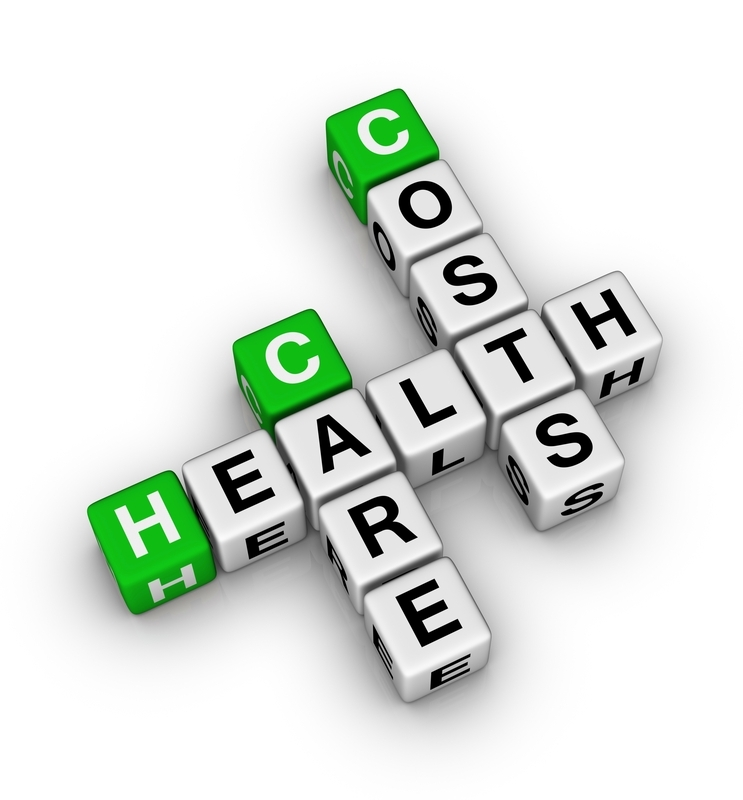

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle

**Data Collection**

In [2]:
df = pd.read_csv('/content/sample_data/insurance.csv')

In [3]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.

Our objective is to find a way to estimate the value in the "expenses" column using the values in the other columns. We can do it for the historical data, then we will estimate expenses for new customers, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

**EDA**

In [4]:
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [6]:
#  Print the more information about the features

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [8]:
df.shape

(1338, 7)

In [9]:
df['sex'].value_counts()

,count
sex,
male,676
female,662


In [10]:
df['smoker'].value_counts()

,count
smoker,
no,1064
yes,274


In [11]:
df.duplicated().sum()

1

In [12]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [13]:
for i in df.columns:
  print(i)
  print(df[i].unique())

age
[19 18 28 33 32 31 46 37 60 25 62 23 56 27 52 30 34 59 63 55 22 26 35 24
 41 38 36 21 48 40 58 53 43 64 20 61 44 57 29 45 54 49 47 51 42 50 39]
sex
['female' 'male']
bmi
[27.9   33.77  33.    22.705 28.88  25.74  33.44  27.74  29.83  25.84
 26.22  26.29  34.4   39.82  42.13  24.6   30.78  23.845 40.3   35.3
 36.005 32.4   34.1   31.92  28.025 27.72  23.085 32.775 17.385 36.3
 35.6   26.315 28.6   28.31  36.4   20.425 32.965 20.8   36.67  39.9
 26.6   36.63  21.78  30.8   37.05  37.3   38.665 34.77  24.53  35.2
 35.625 33.63  28.    34.43  28.69  36.955 31.825 31.68  22.88  37.335
 27.36  33.66  24.7   25.935 22.42  28.9   39.1   36.19  23.98  24.75
 28.5   28.1   32.01  27.4   34.01  29.59  35.53  39.805 26.885 38.285
 37.62  41.23  34.8   22.895 31.16  27.2   26.98  39.49  24.795 31.3
 38.28  19.95  19.3   31.6   25.46  30.115 29.92  27.5   28.4   30.875
 27.94  35.09  29.7   35.72  32.205 28.595 49.06  27.17  23.37  37.1
 23.75  28.975 31.35  33.915 28.785 28.3   37.4   17.765 34

In [14]:
# Let us see statistical information about the Numerical features
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "expenses" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.

The range of expenses in the numerical column seems to have lot of difference in 75 percentile and the maximun expenses it looks like outliers. So we will handle that outlierr.
The range of the bmi in the numerical columns seems to have little difference in 75 percentile and the maximum bmi value.
Almost 50 percent of the customers have one child.

In [15]:
# Let us see more statiscal information of the categorical features
df.describe(include="O")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


**Data Visualization**

In [16]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

Age
Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [17]:
fig = px.histogram(df,
                   x='age',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages.

Body Mass Index
Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [18]:
fig = px.histogram(df,
                    x='bmi',
                    marginal='box',
                    color_discrete_sequence=['red'],
                    title='Distribustion of BMI (Body Mass Index)')

fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a Gaussian distribution centered around the value 30, with a few outliers towards the right. Here's how BMI values can be interpreted (source):

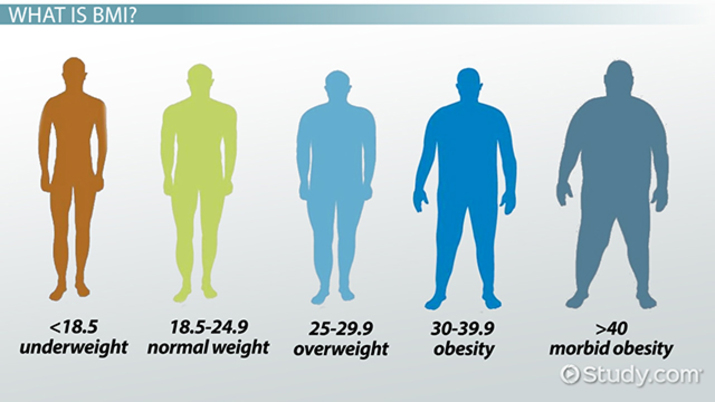

Expenses
Let's visualize the distribution of "expenses" i.e. the annual medical expenses for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the expenses for smokers and non-smokers.

In [20]:
# Verify the correct column name in your DataFrame
print(df.columns)

# Assuming the correct column name is 'charges', modify the code as follows:
fig = px.histogram(df,
                    x='charges',  # Use the correct column name
                    marginal='box',
                    color='smoker',
                    color_discrete_sequence=['green', 'orange'],
                    title="Annual Medical Expenses")

fig.update_layout(bargap=0.1)
fig.show()

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


We can make the following observations from the above graph:

For most customers, the annual medical expenses are under 10k. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is 7.3k, the median for smokers is close to 35k.

Charges and Gender
Let us visualize the distribution of "expenses" with the categorical column "sex" to distinguish the expenses for "male" and "female"

In [23]:
fig = px.histogram(df,
                    x="charges",  # Change 'expenses' to 'charges'
                    marginal="box",
                    color="sex",
                    color_discrete_sequence=["blue", "purple"],
                    title="Annual Medical Expenses by Sex")

fig.update_layout(bargap=0.1)
fig.show()

We can make following observation from the graph

There is a significant difference in expenses between male and female. While the median for male and female is almost same but upper fence for male is 42k, the upper fence for female is close to 28k.

**DIstribution of expenses with Region**

Let's visualize the distribution of "expenses" with categorical column "region" to distinguish expenses for southwest, southeast, northwest and northeast.

In [25]:
fig = px.histogram(df,
                    x="charges",  # Change 'expenses' to 'charges'
                    marginal="box",
                    color="region",
                    color_discrete_sequence=["grey", "orange", "green","violet"],
                    title="Annual Medical Expenses by Region")

fig.update_layout(bargap=0.1)
fig.show()

We make some obervation from the above graph

There is significant difference in expenses for southeast, southwest, northeast and northwest. While the median for southwest is 8798 , the median for southeast is close to 9294, the median for northwest is 8965 and median for northeast is 10.05k.
And the upper fence for southwest is close to 26k, upper fence for southeast is close to 42k, upper fence for northwest is close to 4230kk and the upper fence for northeast is close to 34k.

**Smoker**

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [26]:
px.histogram(df, x="smoker", color="sex", title="Smoker")


From the above graph we make some observations.

It appears that 20% of the customers have reported they smoking.
We can also see that smoking appears a more common habit among males.





In [27]:
px.histogram(df, x="region", color="smoker", title="Region")


In [28]:
px.histogram(df, x="smoker", color="children", title="Smoker Vs Children")


Having looked at individual columns, we can now visualize the relationship between "expenses" (the value we wish to predict) and other columns.

**Age and Charges**

Let's visualize the relationship between "age" and "expenses" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [30]:
fig = px.scatter(df,
                x="age",
                y="charges",  # Changed 'expenses' to 'charges'
                color="smoker",
                opacity=0.8,
                hover_data=["sex"],
                width=800,
                height=500,
                title="Age vs Expenses")

fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

The general trend seems to be that medical expenses increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical expenses.

We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical expenses compared to others

The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".

The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.

**BMI and Expenses**

Let's visualize the relationship between BMI (body mass index) and expenses using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

In [32]:
fig = px.scatter(df,
              x="bmi",
              y="charges",  # Changed 'expenses' to 'charges'
              color="smoker",
              hover_data=['sex'],
              opacity=0.8,
              width=800,
              height=500,
              title="BMI Vs Expenses")  # You might want to adjust the title as well

fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical expenses. However, medical expenses seem to be significantly higher for smokers with a BMI greater than 30.

In [34]:
fig = px.scatter(df,
                x="bmi",
                y="charges",  # Replace 'expenses' with 'charges' if that's the intended column
                color="smoker",
                hover_data=['region'],
                opacity=0.9,
                width=800,
                height=500,
                title= "BMI Vs Charges")  # Adjust the title accordingly

fig.update_traces(marker_size=5)
fig.show()

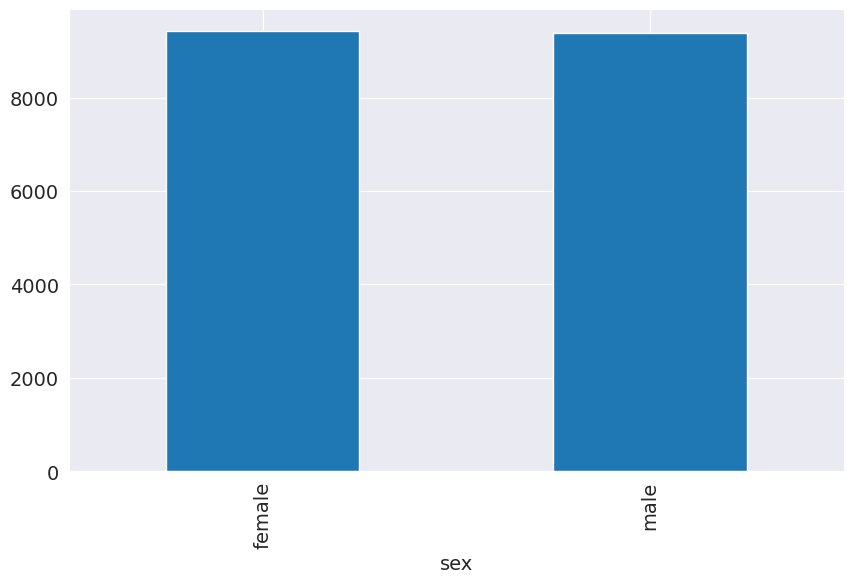

In [36]:
df.groupby("sex")['charges'].median().plot.bar() # Replace 'expenses' with 'charges'
plt.show()

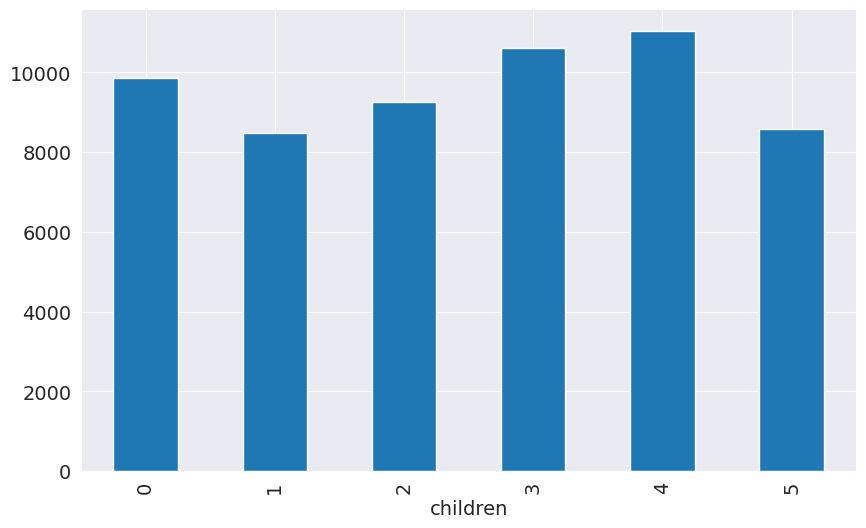

In [38]:
df.groupby("children")['charges'].median().plot.bar() # Use 'charges' instead of 'expenses'
plt.show()

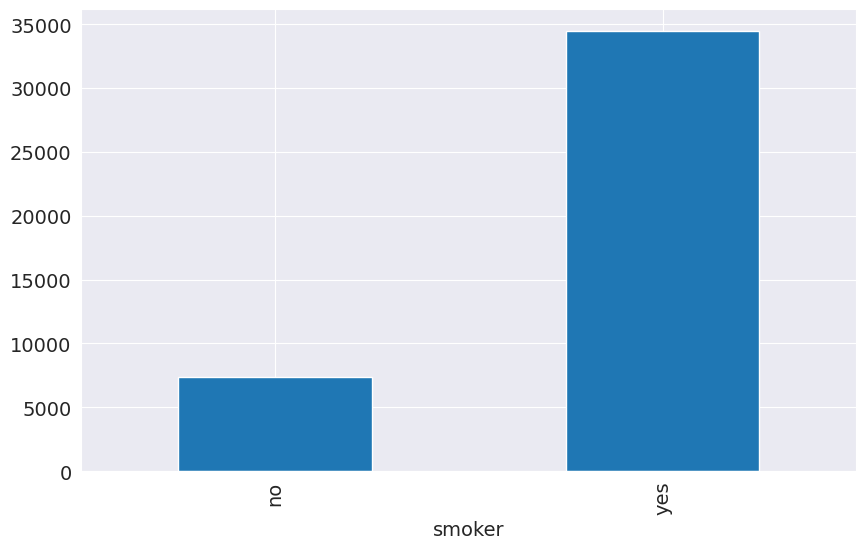

In [40]:
df.groupby("smoker")['charges'].median().plot.bar() # Use 'charges' instead of 'expenses'
plt.show()

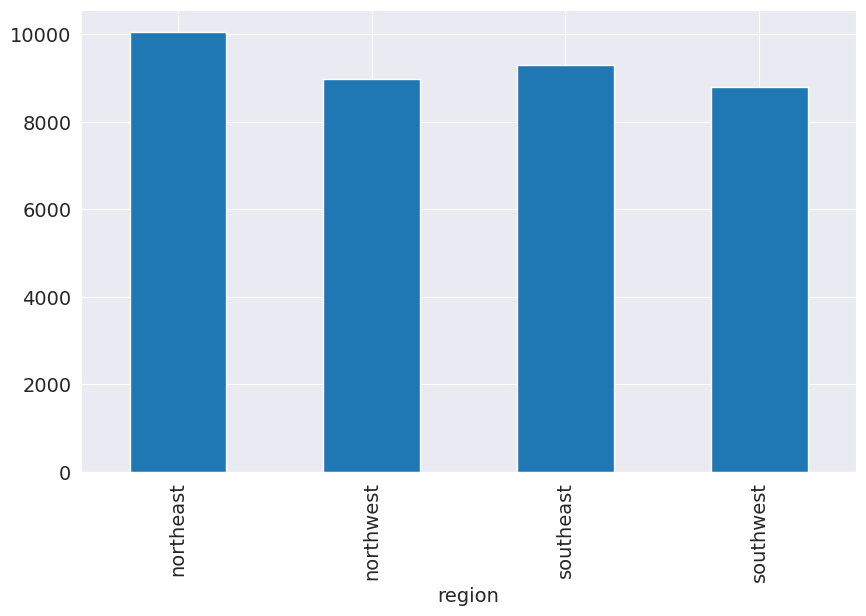

In [42]:
df.groupby("region")['charges'].median().plot.bar() # Use 'charges' instead of 'expenses'
plt.show()

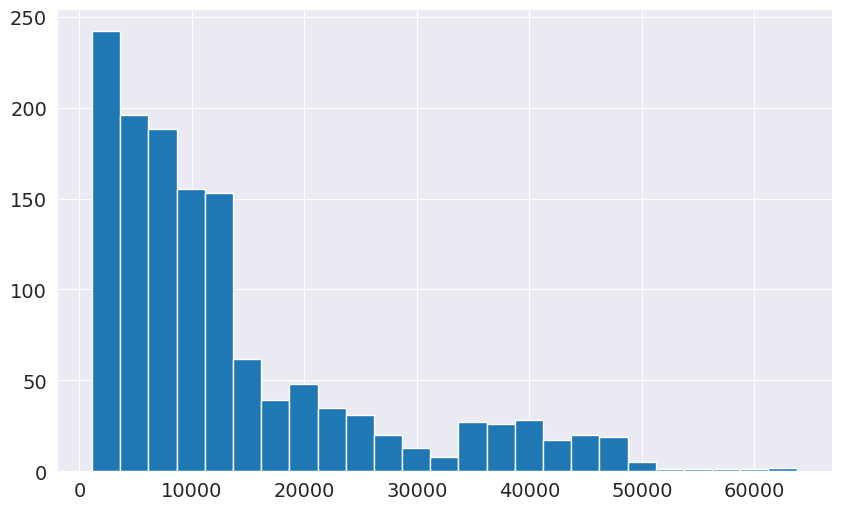

In [44]:
df['charges'].hist(bins=25) # Use 'charges' instead of 'expenses'
plt.show()

In [46]:
fig = px.histogram(data_frame=df, x='bmi', y='charges', width=800, height=500, title='Expenses by BMI') # Changed 'expenses' to 'charges'
fig.show()

In [48]:
fig = px.histogram(df, x="bmi", y="charges", color="sex", marginal="rug", hover_data=df.columns) # Changed 'expenses' to 'charges'
fig.show()

In [50]:
fig = px.scatter(df, x="bmi", y="charges", color='sex', facet_col="children") # Changed 'expenses' to 'charges'
fig.update_xaxes(matches=None)
fig.show()

In [52]:
fig = px.pie(data_frame=df, names='sex', values='charges', width=800, height=500, title='Expenses by Gender') # Use 'charges' instead of 'expenses'
fig.show()

In [54]:
fig = px.scatter(df, x="bmi", y="charges", color="sex", width=900, height=500, title="Expenses by BMI & Gender") # Changed 'expenses' to 'charges'
fig.show()

In [56]:
fig = px.scatter(df, x="bmi", y="charges", color="smoker", width=900, height=500, title="Expenses by BMI & Smoker") # Changed 'expenses' to 'charges'
fig.show()

In [59]:
fig = px.scatter(df, x="bmi", y="charges", color="region", width=900, height=500, title="Expenses by BMI & Region") # Changed 'expenses' to 'charges'
fig.show()

In [60]:
fig = px.violin(df, y="charges", x= "sex") # Use 'charges' instead of 'expenses'
fig.show()

From left plot the insurance charge for male and female is approximatley in same range,it is average around 50k.



In [62]:
fig = px.violin(df, y="charges", x= "smoker") # Use 'charges' instead of 'expenses'
fig.show()


In right plot the health expenses for smokers is much wide range compare to non smokers, the average expenses for non smoker is approximately 5000 bucks. For smoker the minimum health expenses is itself 5000 bucks

In [64]:
fig = px.scatter(df, x="bmi", y="charges", color="sex", marginal_y="violin", # Changed 'expenses' to 'charges'
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

In [66]:
fig = px.scatter(df, x="bmi", y="charges", color="smoker", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white") # Changed 'expenses' to 'charges'
fig.show()

In [68]:
fig = px.scatter(df, x="bmi", y="charges", color="region", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white") # Use 'charges' for the y-axis
fig.show()

In [70]:
fig = px.box(df, x="children", y="charges", color="smoker", notched=True, title= "Expenses by Children & Smoker") # Changed 'expenses' to 'charges'
fig.show()

**Correlation**

In [71]:
# Select only numerical columns before calculating correlations
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


Text(0.5, 1.0, 'Correlation Matrix')

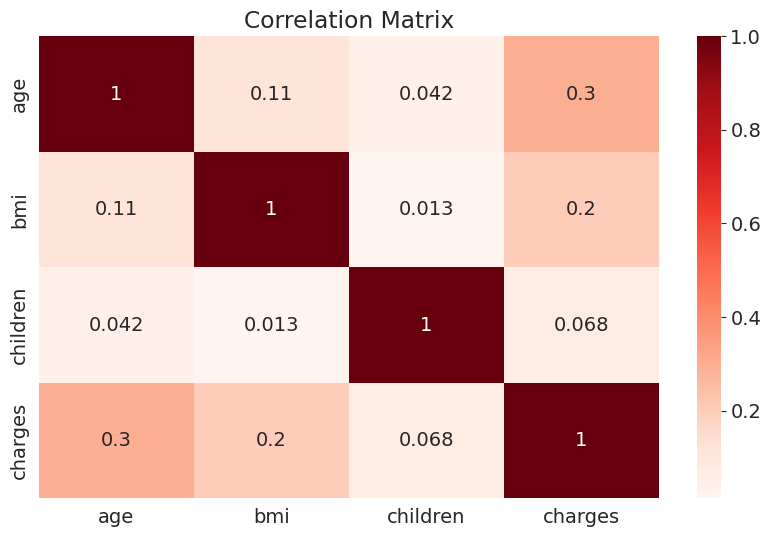

In [72]:
# Select only numerical columns before calculating correlations
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

# Use the numerical DataFrame for the heatmap
sns.heatmap(correlation_matrix, cmap='Reds', annot=True)
plt.title('Correlation Matrix')

Correlation vs causation fallacy: Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features
 and
 can be correlated if
 causes
 or if
 causes
, or if both are caused independently by some other factor
, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that
 are
 simply appear to be correlated because the sample is too small.

As you can tell from the analysis, the values in some columns are more closely related to the values in "expenses" compared to other columns. E.g. "age" and "expenses" seem to grow together, whereas "bmi" and "expenses" don't.

This relationship is often expressed numerically using a measure called the correlation coefficient, which can be computed using the .corr method of a Pandas series.

In [77]:
# Check the column names in your DataFrame
print(df.columns)



Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


In [78]:
# prompt: # Replace 'expenses' with the actual name of the column you want to correlate with 'age'

# Assuming the correct column name is 'charges', modify the code as follows:
df.charges.corr(df.age)  # Replace 'charges' with the actual column name if different


0.2990081933306476

In [80]:
df.charges.corr(df.bmi)


0.19834096883362895

To compute the correlation for categorical columns, they must first be converted into numeric columns.



In [82]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = df.smoker.map(smoker_values)
df.charges.corr(smoker_numeric)  # Replace 'charges' with the actual column name if different

0.787251430498478

Pandas dataframes also provide a .corr method to compute the correlation coefficients between all pairs of numeric columns.



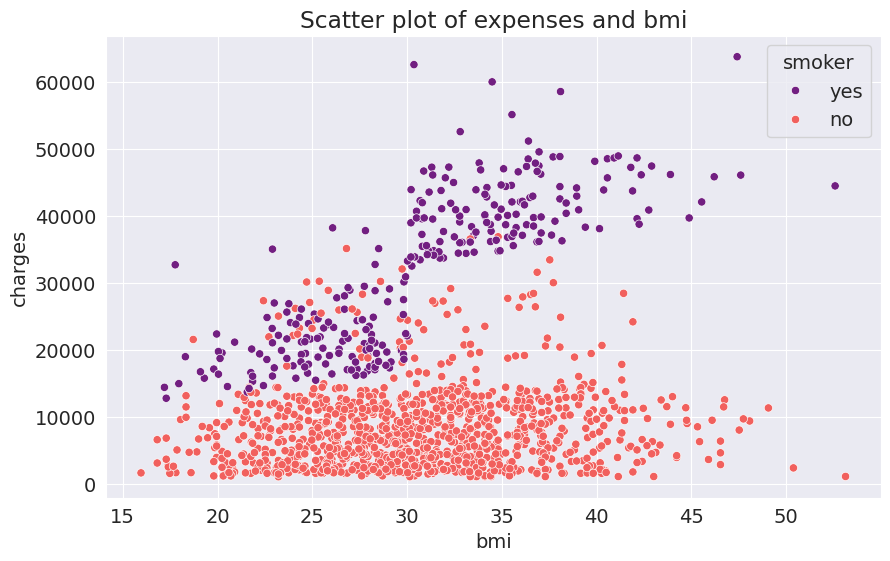

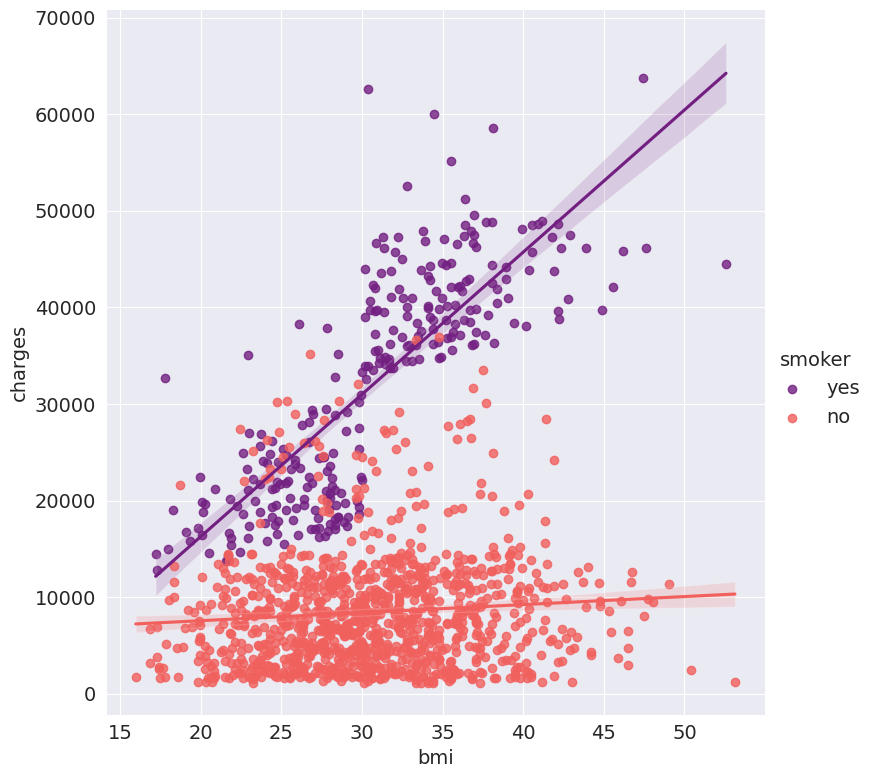

In [85]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='charges',data=df,palette='magma',hue='smoker') # Changed 'expenses' to 'charges'
ax.set_title('Scatter plot of expenses and bmi')

# Use 'height' instead of 'size' to control the plot size
sns.lmplot(x="bmi", y="charges", hue="smoker", data=df, palette = 'magma', height = 8) # Changed 'expenses' to 'charges'

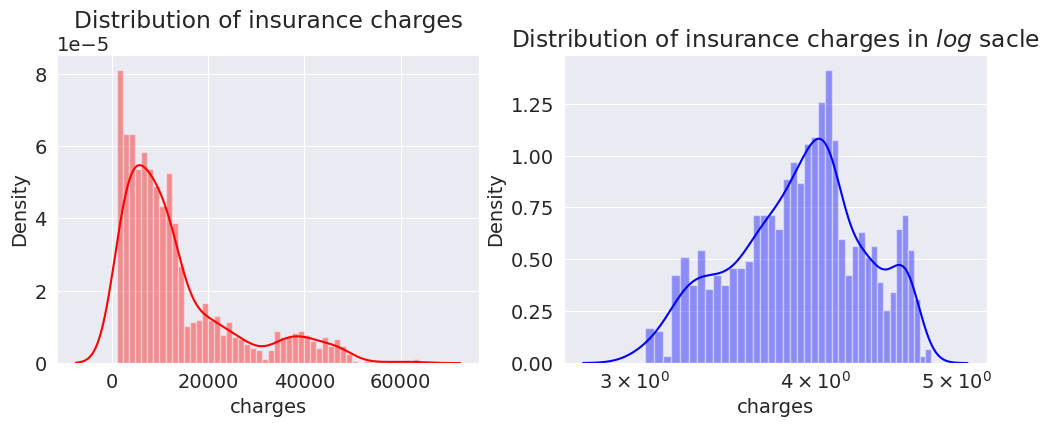

In [87]:


f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
# Use 'charges' instead of 'expenses'
sns.distplot(df['charges'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of insurance charges')

ax=f.add_subplot(122)
# Use 'charges' instead of 'expenses'
sns.distplot(np.log10(df['charges']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of insurance charges in $log$ sacle')
ax.set_xscale('log')

plt.show()

If we look at the left plot the expenses varies from 1120 to 63500, the plot is right skewed. In right plot we will apply natural log, then plot approximately tends to normal. for further analysis we will apply log on target variable charges.



In [90]:
X = df.drop(['charges'], axis=1) # Changed 'expenses' to 'charges'
y = df['charges'] # Changed 'expenses' to 'charges'

In [91]:
# Saving the cleaned data
X.to_csv('clean_data.csv')

In [92]:
# Creating new variables for numerical attributes/columns
numeric_features = ['age', 'bmi', 'children']
# Making pipeline for scaling down numerical features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Creating new variables for categorical attributes/columns
categorical_features = ['sex', 'smoker','region']
# MAking pipeling for Encoding categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Creating new variable for these numerical & categorical features pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [93]:
# Splitting the dataset for training and testing the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
# Let us check shape of the training & test set
print(X_train.shape, y_test.shape)

(1070, 6) (268,)


**Linear** **Regression**


In [95]:
linear_reg = Pipeline(steps=[('prepocessor', preprocessor), ('linear_regressor', LinearRegression())])

linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

linear_reg_mse = mean_squared_error(y_test, y_pred)
linear_reg_rmse = mean_squared_error(y_test, y_pred, squared=False)
linear_reg_r2_score = r2_score(y_test, y_pred)

# Evaluation Metrics
print("The Mean Squared Error using Linear Regression :{}".format(linear_reg_mse))
print(('The Root Mean Squared Error using Linear Regression :{}'.format(linear_reg_rmse)))
print(('The r2_score using Linear Regression :{}'.format(linear_reg_r2_score)))

The Mean Squared Error using Linear Regression :33596915.851361476
The Root Mean Squared Error using Linear Regression :5796.284659276274
The r2_score using Linear Regression :0.7835929767120722


In [96]:
score = []
for i in range(1000):
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=i)
    clf = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score.append(r2_score(y_test, y_pred))

In [97]:
np.argmax(score)


367

In [98]:
score[np.argmax(score)]


0.8328488387235563

**Decision** **Tree**


In [99]:
decision_tree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('decision_tree_regressor', DecisionTreeRegressor(max_depth=4, min_samples_split=4,random_state=42 ))])
decision_tree.fit(X_train, y_train)
# Predicting the model
y_pred1 = decision_tree.predict(X_test)
# Evaluation Metrics
decision_tree_mse = mean_squared_error(y_test, y_pred)
decision_tree_rmse = mean_squared_error(y_test, y_pred1, squared=False)
decision_tree_r2_score = r2_score(y_test, y_pred1)

print("The Mean Squared Error using Decision Tree Regressor : {}".format(decision_tree_mse))
print("The Root Mean Squared Error using Decision Tree Regressor : {}".format(decision_tree_rmse))
print("The r2_score using Decision Tree Regressor : {}".format(decision_tree_r2_score))

The Mean Squared Error using Decision Tree Regressor : 36660548.31208979
The Root Mean Squared Error using Decision Tree Regressor : 4896.51472057015
The r2_score using Decision Tree Regressor : 0.8368489062020883


**Random** **Forest**


In [100]:
random_forest_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('random_forest_regressor', RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42))])
random_forest_reg.fit(X_train, y_train)

# Predicting the model
y_pred2 = random_forest_reg.predict(X_test)

# Evaluation Metrics
random_forest_mse = mean_squared_error(y_test, y_pred2)
random_forest_rmse = mean_squared_error(y_test, y_pred2, squared=False)
random_forest_r2_score = r2_score(y_test, y_pred2)

print("The Mean Squared Error using Random Forest Regressor : {}".format(random_forest_mse))
print("The Root Mean Squared Error using Random Forest Regressor : {}".format(random_forest_rmse))
print("The r2_score Error using Random Forest Regressor : {}".format(random_forest_r2_score))

The Mean Squared Error using Random Forest Regressor : 22322306.061012372
The Root Mean Squared Error using Random Forest Regressor : 4724.648776471366
The r2_score Error using Random Forest Regressor : 0.8481009984437818


In [101]:
random_forest_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('random_forest_regressor', RandomForestRegressor(n_estimators=30, max_depth=4, min_samples_split=5,random_state=42))])
random_forest_reg.fit(X_train, y_train)

# Predicting the model
y_pred2 = random_forest_reg.predict(X_test)

# Evaluation Metrics
random_forest_mse = mean_squared_error(y_test, y_pred2)
random_forest_rmse = mean_squared_error(y_test, y_pred2, squared=False)
random_forest_r2_score = r2_score(y_test, y_pred2)

print("The Mean Squared Error using Random Forest Regressor : {}".format(random_forest_mse))
print("The Root Mean Squared Error using Random Forest Regressor : {}".format(random_forest_rmse))
print("The r2_score Error using Random Forest Regressor : {}".format(random_forest_r2_score))

The Mean Squared Error using Random Forest Regressor : 22141705.30036139
The Root Mean Squared Error using Random Forest Regressor : 4705.497348884748
The r2_score Error using Random Forest Regressor : 0.8493299519017353


**Gradient** **Boosting**


In [102]:
gradient_boosting_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gradient_boosting' , GradientBoostingRegressor())])

gradient_boosting_reg.fit(X_train, y_train)

# Predicting the model
y_pred3 = gradient_boosting_reg.predict(X_test)

# Evaluation Metrics
gradient_boosting_mse = mean_squared_error(y_test, y_pred3)
gradient_boosting_rmse = mean_squared_error(y_test, y_pred3, squared=False)
gradient_boosting_r2_score = r2_score(y_test, y_pred3)

print("The Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_mse))
print("The Root Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_rmse))
print("The r2_sccore using Gradient Boosting Regressor : {}".format(gradient_boosting_r2_score))

The Mean Squared Error using Gradient Boosting Regressor : 22239061.54980765
The Root Mean Squared Error using Gradient Boosting Regressor : 4715.830950087975
The r2_sccore using Gradient Boosting Regressor : 0.8486674613397959


In [103]:
gradient_boosting_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gradient_boosting' , GradientBoostingRegressor(n_estimators=41, max_depth=3, min_samples_split=4, random_state=42))])

gradient_boosting_reg.fit(X_train, y_train)

# Predicting the model
y_pred3 = gradient_boosting_reg.predict(X_test)

# Evaluation Metrics
gradient_boosting_mse = mean_squared_error(y_test, y_pred3)
gradient_boosting_rmse = mean_squared_error(y_test, y_pred3, squared=False)
gradient_boosting_r2_score = r2_score(y_test, y_pred3)

print("The Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_mse))
print("The Root Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_rmse))
print("The r2_sccore using Gradient Boosting Regressor : {}".format(gradient_boosting_r2_score))

The Mean Squared Error using Gradient Boosting Regressor : 21487058.692785524
The Root Mean Squared Error using Gradient Boosting Regressor : 4635.413540643976
The r2_sccore using Gradient Boosting Regressor : 0.8537846962185253


From the above observation we can say that the performance (RMSE & R-sqaured) of Gradient boosting model is good as compared to other models. So we will save Gradient boosting model for further testing of the data using pickle library.



In [104]:
pickle.dump(gradient_boosting_reg, open('gradient_boosting_regressor_model.pkl', 'wb'))
